In [96]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import dcor

import sys
sys.path.append("/home/yangz2/projects/1906-pcgml/pcgml-gmmVae-exp/modules/")

from metrics import Metrics
m = Metrics(game='smba')

In [97]:
path_to_gens = "../smba_generations"
os.listdir(path_to_gens)

['smba_gmvae_8.json',
 'smba_gmvae_28.json',
 'smba_gmvae_68.json',
 'smba_gmvae_88.json',
 'smba_gmvae_108.json',
 'smba_gmvae_128.json',
 'smbWithPath-allLevels-chunks-int-Copy1.json',
 'smba_gmvae_1.json',
 'smba_gmvae_48.json']

In [98]:
def load_json_as_array(json_fpath):
    with open(json_fpath, "r") as json_f:
        return np.array(json.load(json_f))

In [99]:
def get_metrics_from_chunks(chunks):
    return m.compute_metrics_for_arrays(
        arrays=chunks, 
        metrics_to_compute=['linearity', 'leniency', 'num_jumps', 'density', 'interestingness']
    )

In [100]:
metrics_per_json = []
for json_fname in tqdm_notebook(os.listdir(path_to_gens)):
    json_fpath = os.path.join(path_to_gens, json_fname)
    chunks = load_json_as_array(json_fpath)
    metrics_per_json.append(get_metrics_from_chunks(chunks))

In [101]:
metrics_per_json_np = [np.array(i) for i in metrics_per_json]

In [102]:
with open('metrics_per_json.json', 'w+') as json_f:
    json.dump([i.tolist() for i in metrics_per_json_np], json_f)

In [103]:
with open('metrics_per_json.json', 'r') as json_f:
    metrics_per_json_np = [np.array(i) for i in json.load(json_f)]

In [104]:
# make sure all metrics are on the same scale
for i in metrics_per_json_np:
    i -= i.mean(axis=1).reshape(-1, 1)
    i /= i.std(axis=1).reshape(-1, 1)

In [105]:
for i in metrics_per_json_np:
    print(i.mean(axis=1))
    print(i.std(axis=1))

[-5.68434189e-17  6.53699317e-17 -1.02318154e-16  1.36424205e-16
 -3.41060513e-17]
[1. 1. 1. 1. 1.]
[ 5.68661653e-17  1.13732331e-17 -1.50695338e-16  2.27464661e-17
 -1.13732331e-17]
[1. 1. 1. 1. 1.]
[ 5.68661653e-18  3.41196992e-17  5.68661653e-17 -1.42165413e-16
  1.13732331e-17]
[1. 1. 1. 1. 1.]
[-1.14327069e-17  5.71635347e-18 -7.85998602e-18  1.62916074e-16
 -1.14327069e-17]
[1. 1. 1. 1. 1.]
[-1.37302944e-16 -1.71628680e-17  0.00000000e+00 -1.60186768e-16
  1.71628680e-17]
[1. 1. 1. 1. 1.]
[-3.62957527e-17 -2.56205313e-17  1.02482125e-16  0.00000000e+00
 -9.25185854e-18]
[1. 1. 1. 1. 1.]
[-5.26718114e-17  0.00000000e+00  5.26718114e-17 -1.89618521e-16
 -3.42366774e-17]
[1. 1. 1. 1. 1.]
[-6.89226454e-17 -2.87769808e-17  1.13686838e-17 -8.70414851e-17
  9.76996262e-17]
[1. 1. 1. 1. 1.]
[-2.70438942e-17  1.13869028e-17 -1.36642834e-16 -1.70803542e-16
 -3.13139827e-17]
[1. 1. 1. 1. 1.]


In [106]:
org_idx = 6
org_mets = metrics_per_json_np[org_idx]
e_distances = []
for i, mets in enumerate(metrics_per_json_np):
    if (i != org_idx):
        e_distances.append(dcor.energy_distance(org_mets.T, mets.T))

In [111]:
num_components_array = [8, 28, 68, 88, 108, 128, 1, 48]
e_distances

[0.05078401263852905,
 0.0686465776595706,
 0.11198868589141897,
 0.09333824583125727,
 0.0581212034446259,
 0.07029160174213489,
 0.07418419190912573,
 0.07887983917107322]

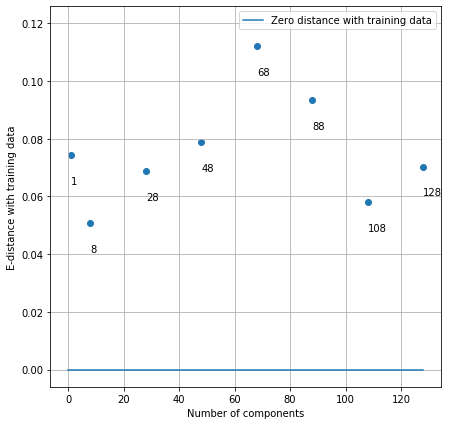

In [127]:
plt.figure(figsize=(7, 7))
plt.scatter(num_components_array, e_distances)
plt.plot([0, 128], [0, 0], label='Zero distance with training data')
for x, y in zip(num_components_array, e_distances):
    plt.annotate(x, xy=(x, y-0.01))
plt.xlabel('Number of components'); plt.ylabel('E-distance with training data')
plt.legend()
plt.grid()
plt.show()

TODO:
- Construct bootsrap confidence intervals for the plot above
- Train more epochs so GM-VAEs have more time to discover the structure
- Train models from 1-10 components because maybe less components is more semantically meaningful and thus help with generation